In [1]:
import numpy as np
import PWBeamformer as pwb
import matplotlib.pyplot as plt
import scipy.signal as sig
import pyus.data.io as dio

In [5]:
# Load file
print("Reading file")
filedir = "/datacommons/ultrasound/TIMuscle/Phantoms/20230208_developmentrf/acq_wire/"
filename = "20230208_153318694"

params = dio.loadmat(filename=filename+"_RF", filedir=filedir)
nsamp = 2*4*(params['track_params']['rx']['endDepth'] - params['track_params']['startDepth'])
nsamp = int(np.ceil(nsamp/128) * 128)
rf_raw = np.fromfile(filedir+filename+"_RF.bin", dtype=np.int16)
rf_raw = rf_raw.reshape((-1,params['trans']['nele']), order='f')

na = params['track_params']['rf']['na']
numrot = params['track_params']['numrot']

print("Reshaping")
rf = []
for rot in range(numrot):
    rotdata = []
    for ang in range(na):
        indmin = (rot*na + ang)*nsamp
        indmax = indmin + nsamp
        rotdata.append(rf_raw[indmin:indmax,:])
    rf.append(rotdata)
rf = np.array(rf).transpose(2, 3, 1, 0).astype(float)
fs = 20.833E6

print("UPsamplng")
usf_ax = int(8)
t = params['track_params']['startDepth']/params['f'] + np.arange(nsamp)/fs
tstart = params['track_params']['startDepth']/params['f']
rf, t = sig.resample(rf, rf.shape[0]*usf_ax, t, axis=0)
Ts = np.mean(np.diff(t))
Nt = len(t)

print("  ", rf.shape)

print("image parameters")
# IMaging parameters
c = 1540        # speed of sound in medium [m/s - coldish water]
fs = 20.833E6   # sampling frequency [Hz]
ddeg = params['track_params']['rf']['ddeg']
dtheta = ddeg * np.pi/180
na = params['track_params']['rf']['na']
thetas = dtheta*(np.arange(na)-(na-1)/2)

# Transducer parameters
dele = 0.298E-3 # element spacing [meters]
nele = 128      # number of elements

# Recon parameters
dz = c/(4*fs)
zmin = 1.5E-3
zmax = 40E-3
dx = 0.2E-3
xmin = -dele * (nele-1)/2
xmax = dele * (nele-1)/2
dy = 0.2E-3
ymin = 0E-3
ymax = 0E-3

# Generate element grid
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele)
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# Generate recon grid
xgrid = np.arange(xmin, xmax, dx)
ygrid = 0 #np.arange(ymin, ymax, dy)
zgrid = np.arange(zmin, zmax, dz)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid)
field = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

thetas = dtheta*(np.arange(na)-(na-1)/2)

trefs = []
for inda in range(na):
    tref = np.sin(thetas[inda])*xele/c
    tref = tref - np.min(tref)
    trefs.append(tref)
trefs = np.array(trefs).flatten()

print(trefs.shape)

# initialize beamformer
funcparams = {}
funcparams['c'] = c
funcparams['fnum'] = 2
funcparams['points'] = field
funcparams['trefs'] = np.array([trefs[0]])
funcparams['refs'] = eles[0,:].reshape((1,3))
funcparams['alphas'] = np.array([thetas[0]])
funcparams['nsamp'] = rf.shape[0]
funcparams['fs'] = 1/Ts
funcparams['tstart'] = 5*c/params['f']

for (k, v) in params.items():
    try:
        print(k, v.shape)
    except Exception as e:
        print(k, "welp...")

Reading file
Reshaping
UPsamplng
   (12288, 128, 11, 36)
image parameters
(1408,)
c ()
f ()
lambda ()
numTransmit ()
numRcvChannels ()
trans welp...
bmode welp...
track welp...
bmode_params welp...
track_params welp...


In [6]:
bmfrm = pwb.PWBeamformer(**funcparams)

Initializing a PWBeamformer...
  Formatting input parameters...
  Putting shared values...
    Allocating trefs...
    Allocating points...
    Allocating tinds...
    Allocating masks...
    Allocating databuffer...
    Allocating result buffers...
  Registering beamformer with global indexes
  Filling tables
    Generating masks
    Generating Transmission Tabs


In [7]:
print("Slicing data")
rfslice = rf[:,:,0,0]
for ind in range(rf.shape[2]-1):
    rfslice = np.concatenate((rfslice, rf[:,:,ind+1,0]), axis = 1)
rfslice.shape

Slicing data


(12288, 1408)

In [8]:
bmfrmparams = pwb.__BMFRM_PARAMS__[bmfrm.id]

In [9]:
summed = bmfrm(rfslice[:,0].reshape((-1, 1)))
print("Finished with it")

Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Finished with it


/tmp/ipykernel_148410/3925312493.py:3: RuntimeWarning: invalid value encountered in divide
  logged = 20*np.log10(env/np.max(env))


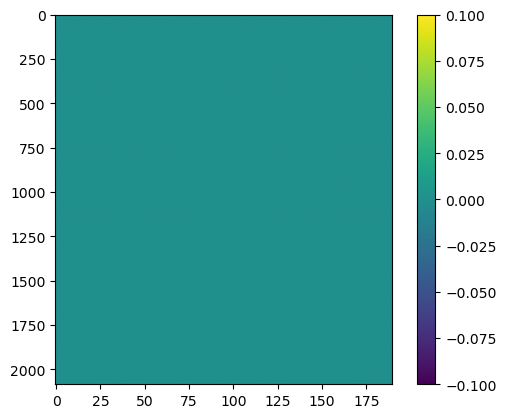

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
summed = np.abs(summed.reshape((len(zgrid), len(xgrid)), order='f'))
env = np.abs(sig.hilbert(summed, axis=0))
logged = 20*np.log10(env/np.max(env))
plt.figure()
plt.imshow(env, aspect = 0.1)
plt.colorbar()
plt.show()
print(env)

In [ ]:
tinds = np.array([np.array(bmfrmparams['tinds'][ind]) for ind in range(len(bmfrmparams['tinds']))])
tinds.shape

(1, 395960)

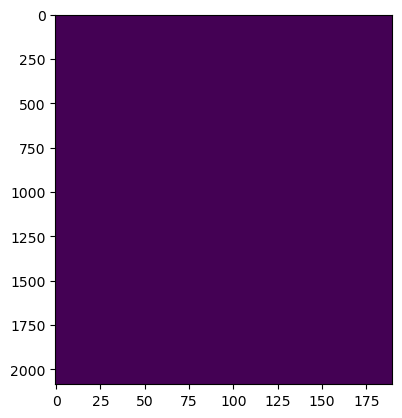

In [ ]:
delays = tinds[0,:].reshape((len(zgrid), -1), order='f')

plt.figure()
plt.imshow(delays, aspect=0.1)
plt.show()

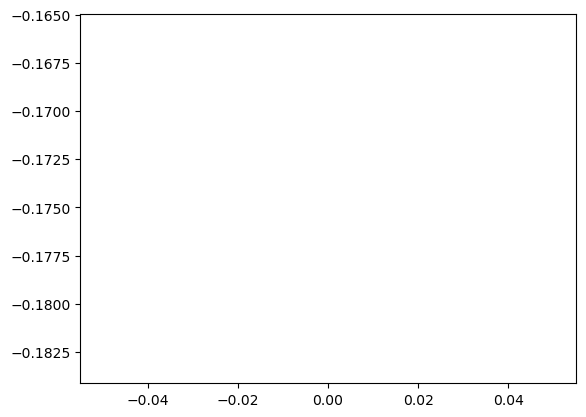

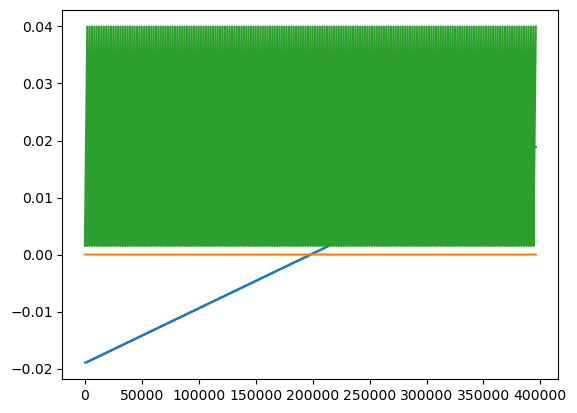

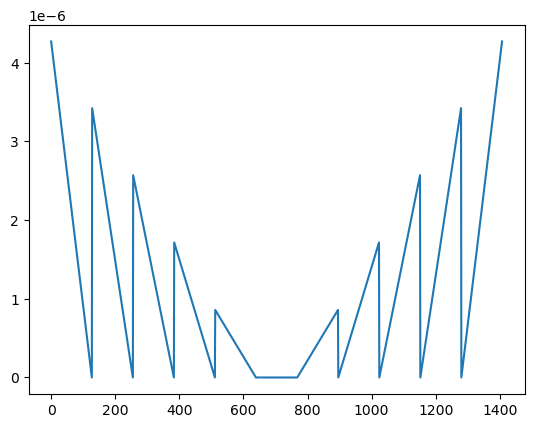

In [ ]:
plt.figure()
plt.plot(bmfrmparams['alphas'])
plt.show()

plt.figure()
points_found = np.array([np.array(bmfrmparams['points'][ind]) for ind in range(len(bmfrmparams['points']))])
plt.plot(bmfrmparams['points'][0::3])
plt.plot(bmfrmparams['points'][1::3])
plt.plot(bmfrmparams['points'][2::3])
plt.show()

trefs_found = np.array([np.array(bmfrmparams['trefs'][ind]) for ind in range(len(bmfrmparams['trefs']))])
plt.figure()
plt.plot(trefs)
plt.plot(trefs_found)
plt.show()

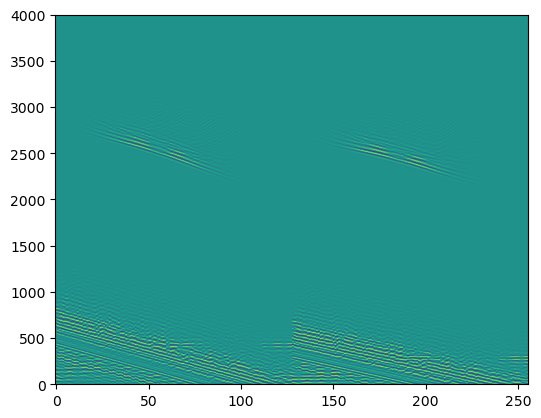

In [ ]:

plt.figure()
plt.imshow(rfslice[:,:2*128], aspect=0.05)
plt.ylim(0, 4000)
plt.show()